### Week 7 - Time Series Forecasting with Recurrent Neural Networks

In [52]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
%matplotlib inline

In [53]:
df = pd.read_csv('household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [54]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [55]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [56]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [57]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [58]:
global_energy_df = df.Global_active_power
global_energy_df = pd.DataFrame(global_energy_df)
global_energy_df = global_energy_df.dropna()
global_energy_df

,Global_active_power
dt,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666
...,...
2010-11-26 20:58:00,0.946
2010-11-26 20:59:00,0.944
2010-11-26 21:00:00,0.938


<AxesSubplot: title={'center': 'Global_active_power resampled over day for sum'}, xlabel='dt'>

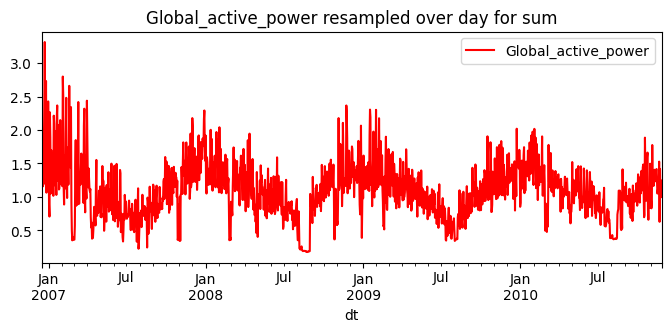

In [59]:
global_energy_df.resample('D').mean().plot(title='Global_active_power resampled over day for sum', color='red', figsize=(8, 3))

In [60]:
global_energy_df = global_energy_df.resample('H').mean() 
global_energy_df

,Global_active_power
dt,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467
...,...
2010-11-26 17:00:00,1.725900
2010-11-26 18:00:00,1.573467
2010-11-26 19:00:00,1.659333


In [61]:
global_energy_df.isnull().sum()

Global_active_power    0
dtype: int64

In [62]:
global_active_power = global_energy_df['Global_active_power']

In [63]:
global_active_power = global_active_power.astype('float32')
global_active_power

dt
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
                         ...   
2010-11-26 17:00:00    1.725900
2010-11-26 18:00:00    1.573467
2010-11-26 19:00:00    1.659333
2010-11-26 20:00:00    1.163700
2010-11-26 21:00:00    0.934667
Freq: H, Name: Global_active_power, Length: 34589, dtype: float32

In [64]:
# train-test split for time series
train_size = int(len(global_active_power) * 0.67)
test_size = len(global_active_power) - train_size
train, test = global_active_power[:train_size], global_active_power[train_size:]

In [65]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [80]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([23170, 4]) torch.Size([23170, 4])
torch.Size([11411, 4]) torch.Size([11411, 4])


In [81]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [82]:
import torch.optim as optim
import torch.utils.data as data


model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 2 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.5555, test RMSE 0.4967


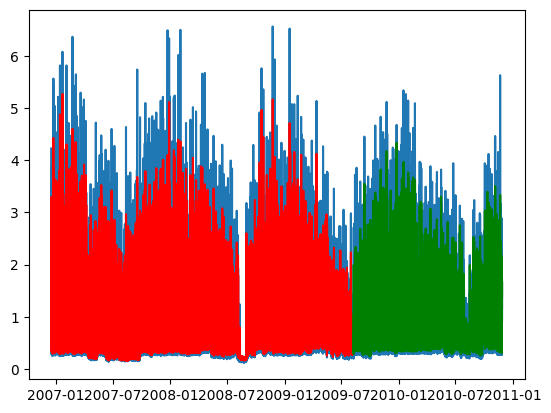

In [88]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(global_active_power) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)[:, -1]
    train_plot = pd.Series(train_plot, index=global_active_power.index)
    # shift test predictions for plotting
    test_plot = np.ones_like(global_active_power) * np.nan
    test_plot[train_size+lookback:len(global_active_power)] = model(X_test)[:, -1]
    test_plot = pd.Series(test_plot, index=global_active_power.index)
# plot
plt.plot(global_active_power)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()